[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prabuscihero/NLP-Basic-to-Bert/blob/master/Ulmfit.ipynb)

## Model - Ulmfit

In [0]:
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.pipeline import Pipeline
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from torchtext.vocab import GloVe
import pickle
from sklearn.model_selection import GridSearchCV
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

In [5]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
cd '/content/gdrive/My Drive/Colab Notebooks/NLP-Basic-to-Bert'

/content/gdrive/My Drive/Colab Notebooks/NLP-Basic-to-Bert


In [0]:
# Load the training data
train_df_full = pd.read_csv('training_data.csv')
test_df = pd.read_csv('testing_data.csv')

In [0]:
# Create train and validation set
train_df, valid_df, train_labels, valid_labels = train_test_split(train_df_full, train_df_full.user_rating, random_state=42, stratify=train_df_full.user_rating,test_size=0.20)

In [9]:
#Create a TextDataBunch suitable for training a language model.
path = ""
data_lm = TextLMDataBunch.from_df(path, train_df, valid_df,min_freq=1,text_cols = 'user_review', label_cols = 'user_rating')

In [10]:
data_lm.save()
data_lm.show_batch()

idx,text
0,more xxmaj give it up xxmaj donny xxbos xxmaj unhappy competition xxmaj this album is wonderful i can listen to it for hours and i m 65 years old xxmaj please be cautious in believing critical reviews as some people are unhappy that xxmaj clays album came out before xxmaj rubens i m sure xxmaj rubens album will be really great also xxbos xxmaj very annoying xxmaj this video is
1,app more than once to get it to work right xxbos xxmaj not so hot i confess i did nt play past the first level but heres why xxmaj the colors are so bright in this cartoongraphics game it can give you a headache xxmaj then on the first level a dinosaur kept coming out of nowhere and jumping on my xxmaj taz delaying the game as xxmaj taz recovered
2,long novel with an intricate plot i enjoyed it a lot xxmaj other reviewers have covered the plot and given their opinions xxmaj ill just give one tip xxmaj unless you can clear your calendar so you can read without interruptions i d recommend buying the xxmaj kindle version of this book if you can xxmaj that way if you have to put it down for a while and come
3,pushed to the max xxmaj mixed for ipods i quess i m an old guylouder in your face is not better xxbos xxmaj andrew xxmaj adamson has done it again xxmaj this is the sequel to the lion the witch and the wardrobe which was an awesome movie i still remember when my aunty first bought me the xxmaj chronicles of xxmaj narnia book collection xxmaj once i started reading
4,a small chested womansize xxup dd cupsand i love high impact sports but i have had a difficult time finding a sports bra that could keep me from painfully bouncing everytime i would run or jump xxmaj this bra keeps that from happening i no longer feel pain when playing sports or runningi also do nt feel as selfconscious when working out which is another added bonusthe bra is comfortable


In [11]:
#Create a TextDataBunch suitable for training an RNN classifier.
data_clas = TextClasDataBunch.from_df(path, train_df, valid_df, test_df,vocab=data_lm.train_ds.vocab, text_cols = 'user_review', label_cols = 'user_rating',bs=16)

In [12]:
data_clas.save()
data_clas.show_batch()

text,target
xxbos xxup this xxup sucks xxup stay xxup away xxup buyer xxup beware xxup yes xxup the xxup diapers xxup are xxup good xxup but i xxup received xxup the xxup diapers xxup with xxup stains xxup they xxup look xxup like xxup dna xxup stains xxup so i xxup call xxup the xxup company xxup and xxup they xxup instruct xxup me xxup to xxup xxunk xxup them xxup,0
xxbos xxup devin xxup the xxup dudes xxup biggest xxup fan xxup devin xxup is a xxup great xxup rapper xxup but xxup who xxup is xxup very xxup underrated i xxup have xxup all xxup of xxup his xxup cd xxup even xxup though xxup he xxup dosent xxup get xxup allot a xxup play xxup down xxup here xxup in xxup jacksonville xxup xxunk xxup waitin xxup to,1
xxbos xxmaj clancys xxmaj second xxmaj best i ve read the majority of xxmaj clancys books in the past year and i find him great one of the best authors xxmaj up there with xxmaj dean xxmaj koontz xxmaj stephen xxmaj king xxmaj robert xxmaj xxunk and xxmaj micheal xxmaj xxunk xxmaj now the best book xxunk xxmaj tom was xxmaj rainbow xxmaj six and this came in a close,1
xxbos xxmaj do yourself a favor and buy this tape xxmaj after the new tas known as xxmaj fakes arrive on the scene a xxunk starts and ends in a sand storm xxmaj that fight is continued later in the episode as the team of tas walk right into the xxmaj fakes trap xxmaj the battle concludes leaving the tas with a sample of the xxmaj fakes xxmaj the second,1
xxbos xxmaj this book is awful i am currently reading xxmaj the xxmaj hobbit against my will i am in an advanced reading class and this is the great book that the teacher is forcing us to read and testing us over it i am about 80 pages away from the end and this book xxup bites i can not even concentrate on what i am reading because the book,0


In [0]:
# Download the pretrained language model
learn = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


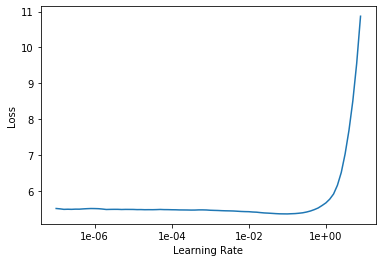

In [0]:
# Plot different learning rate and select the best learning rate
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
# Fine tune the language model with the review data
learn = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.3)
learn.fit_one_cycle(1, slice(1e-4,1e-1), moms=(0.8, 0.7))
learn.save_encoder('ft_enc1')
print("done")

epoch,train_loss,valid_loss,accuracy,time
0,5.109914,4.742639,0.219441,03:11


done


In [0]:

learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4, 1e-1), moms=(0.8, 0.7))
learn.save_encoder('ft_enc2')
print("done")

epoch,train_loss,valid_loss,accuracy,time
0,4.683995,4.520857,0.236070,03:35
1,4.602182,4.426942,0.246573,03:35
2,4.377951,4.274166,0.259523,03:35
3,4.069189,4.141726,0.273393,03:36
4,3.689270,4.150926,0.275364,03:35


done


In [0]:
# Predict the next words on the review data
learn.predict("This is a review about", n_words=15)

'This is a review about her thank a film to will turnso Class very Broadband and the last'

In [45]:
# Build the text classification model with user review trained model
learn_class = text_classifier_learner(data_clas, arch = AWD_LSTM, pretrained = True, drop_mult=0.1)
learn_class.load_encoder('ft_enc2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (40000 items)
x: TextList
xxbos dumb dumber i did nt like the video xxmaj how could all xxmaj josephs brothers be of a different race xxmaj are we trying to be politically correct or xxup what xxmaj also i wish xxmaj donny had kept his shirt on i was turned on by his hairy chest i have seen this performed twice by groups other than xxmaj donny and co and enjoyed it so much more xxmaj give it up xxmaj donny,xxbos xxmaj unhappy competition xxmaj this album is wonderful i can listen to it for hours and i m 65 years old xxmaj please be cautious in believing critical reviews as some people are unhappy that xxmaj clays album came out before xxmaj rubens i m sure xxmaj rubens album will be really great also,xxbos xxmaj very annoying xxmaj this video is really a disappointment it came with a xxmaj thomas piece so naturally my daughter picked it and i thought the bonus feature would nt be mixed in with the actually xxmaj thomas stories but i 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


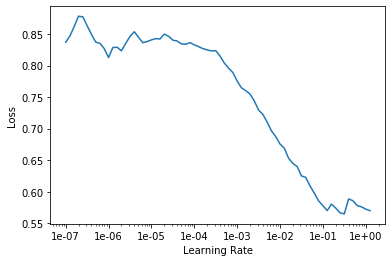

In [46]:
# Plot different learning rate and select the best learning rate
learn_class.lr_find(start_lr=1e-8, end_lr=1e2)
learn_class.recorder.plot()

In [47]:
# Fine tune the classification model with the review data
learn_class.fit_one_cycle(1, slice(1e-4, 1e-1), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.298723,0.237325,0.905200,02:15


In [48]:
learn_class.unfreeze()
learn_class.fit_one_cycle(1, slice(1e-4, 1e-1), moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.219907,0.189590,0.925700,04:33


In [49]:
learn_class.unfreeze()
learn_class.fit_one_cycle(1, slice(1e-4, 1e-1), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.192672,0.185145,0.927600,04:27


In [50]:
# Predict the test data
prediction, test_class =learn_class.get_preds(ds_type=DatasetType.Test,ordered=True)
pred_class = torch.argmax(prediction, dim=1)

In [51]:
print(classification_report(test_df.user_rating,pred_class))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     24626
           1       0.93      0.92      0.93     25374

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000

